In [1]:
import os
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
      files_dic = os.path.join(dirname, filename)
      print(files_dic)

../data\.gitignore
../data\AdSmartABdata.csv
../data\AdSmartABdata.csv.dvc
../data\Chrome_MobileAdSmartABdata.csv
../data\Chrome_WebViewAdSmartABdata.csv
../data\FacebookAdSmartABdata.csv
../data\platform_5_AdSmartABdata.csv
../data\platform_6_AdSmartABdata.csv
../data\samsug_internetAdSmartABdata.csv
../data\split_AdSmartABdata.csv


In [2]:
# Importing Pandas an Numpy Libraries to use on manipulating our Data
import pandas as pd
import numpy as np

# To Preproccesing our data
from sklearn.preprocessing import LabelEncoder

# To fill missing values
from sklearn.impute import SimpleImputer

# To Split our train data
from sklearn.model_selection import train_test_split

# To Visualize Data
import matplotlib.pyplot as plt
import seaborn as sns

# To Train our data
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB

# To evaluate end result we have
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score


# We are importing our Data with Pandas Library
# We use "Coronary_artery.csv" 
df = pd.read_csv("../data\Chrome_WebViewAdSmartABdata.csv")

In [3]:
df  = df.drop(['auction_id','Unnamed: 0'], axis = 1)


In [4]:
df.head()

,experiment,date,hour,device_make,platform_os,browser,yes,no
0,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
1,exposed,2020-07-05,6,I3312,6,Chrome Mobile WebView,0,1
2,exposed,2020-07-09,20,Moto $2,6,Chrome Mobile WebView,0,1
3,control,2020-07-06,2,Samsung SM-J600FN,6,Chrome Mobile WebView,0,1
4,exposed,2020-07-04,11,Samsung SM-G981B,6,Chrome Mobile WebView,1,0


In [5]:
numerical_column = df.select_dtypes(exclude="object").columns.tolist()
categorical_column = df.select_dtypes(include="object").columns.tolist()
print("Numerical Columns:", numerical_column)
print("****************")
print("Categorical Columns:", categorical_column)

Numerical Columns: ['hour', 'platform_os', 'yes', 'no']
****************
Categorical Columns: ['experiment', 'date', 'device_make', 'browser']


In [6]:
# Get column names have less than 10 more than 2 unique values
to_one_hot_encoding = [col for col in categorical_column if df[col].nunique() <= 10 and df[col].nunique() > 2]

# Get Categorical Column names thoose are not in "to_one_hot_encoding"
to_label_encoding = [col for col in categorical_column if not col in to_one_hot_encoding]

print("To One Hot Encoding:", to_one_hot_encoding)
print("To Label Encoding:", to_label_encoding)

To One Hot Encoding: ['date']
To Label Encoding: ['experiment', 'device_make', 'browser']


In [7]:

label_encoded_columns = []
# For loop for each columns
for col in to_label_encoding:
    # We define new label encoder to each new column
    le = LabelEncoder()
    # Encode our data and create new Dataframe of it, 
    # notice that we gave column name in "columns" arguments
    column_dataframe = pd.DataFrame(le.fit_transform(df[col]), columns=[col] )
    # and add new DataFrame to "label_encoded_columns" list
    label_encoded_columns.append(column_dataframe)

# Merge all data frames
label_encoded_columns = pd.concat(label_encoded_columns, axis=1)
label_encoded_columns

,experiment,device_make,browser
0,1,3,0
1,1,11,0
2,1,16,0
3,0,63,0
4,1,57,0
...,...,...,...
222,1,30,0
223,1,74,0
224,1,10,0
225,0,36,0


In [8]:
# We will use built in pandas function "get_dummies()" to simply to encode "to_one_hot_encoding" columns
one_hot_encoded_columns = pd.get_dummies(df[to_one_hot_encoding])
one_hot_encoded_columns

,date_2020-07-03,date_2020-07-04,date_2020-07-05,date_2020-07-06,date_2020-07-07,date_2020-07-08,date_2020-07-09,date_2020-07-10
0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
222,0,0,0,0,0,0,0,1
223,0,1,0,0,0,0,0,0
224,0,1,0,0,0,0,0,0
225,0,0,0,0,0,0,0,1


In [9]:
# Copy our DataFrame to X variable
X = df.copy()

# Droping Categorical Columns,
# "inplace" means replace our data with new one
# Don't forget to "axis=1"
X.drop(categorical_column, axis=1, inplace=True)

# Merge DataFrames
X = pd.concat([X, one_hot_encoded_columns, label_encoded_columns], axis=1)
print("All columns:", X.columns.tolist())
X

All columns: ['hour', 'platform_os', 'yes', 'no', 'date_2020-07-03', 'date_2020-07-04', 'date_2020-07-05', 'date_2020-07-06', 'date_2020-07-07', 'date_2020-07-08', 'date_2020-07-09', 'date_2020-07-10', 'experiment', 'device_make', 'browser']


,hour,platform_os,yes,no,date_2020-07-03,date_2020-07-04,date_2020-07-05,date_2020-07-06,date_2020-07-07,date_2020-07-08,date_2020-07-09,date_2020-07-10,experiment,device_make,browser
0,2,6,0,1,0,0,1,0,0,0,0,0,1,3,0
1,6,6,0,1,0,0,1,0,0,0,0,0,1,11,0
2,20,6,0,1,0,0,0,0,0,0,1,0,1,16,0
3,2,6,0,1,0,0,0,1,0,0,0,0,0,63,0
4,11,6,1,0,0,1,0,0,0,0,0,0,1,57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,8,6,0,1,0,0,0,0,0,0,0,1,1,30,0
223,13,6,1,0,0,1,0,0,0,0,0,0,1,74,0
224,6,6,1,0,0,1,0,0,0,0,0,0,1,10,0
225,12,6,0,1,0,0,0,0,0,0,0,1,0,36,0


In [10]:
y = df["yes"]

# Droping "class" from X
X.drop(["yes"], axis=1, inplace=True)
X


,hour,platform_os,no,date_2020-07-03,date_2020-07-04,date_2020-07-05,date_2020-07-06,date_2020-07-07,date_2020-07-08,date_2020-07-09,date_2020-07-10,experiment,device_make,browser
0,2,6,1,0,0,1,0,0,0,0,0,1,3,0
1,6,6,1,0,0,1,0,0,0,0,0,1,11,0
2,20,6,1,0,0,0,0,0,0,1,0,1,16,0
3,2,6,1,0,0,0,1,0,0,0,0,0,63,0
4,11,6,0,0,1,0,0,0,0,0,0,1,57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,8,6,1,0,0,0,0,0,0,0,1,1,30,0
223,13,6,0,0,1,0,0,0,0,0,0,1,74,0
224,6,6,0,0,1,0,0,0,0,0,0,1,10,0
225,12,6,1,0,0,0,0,0,0,0,1,0,36,0


In [11]:
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.333)

In [12]:
### Random Forest

# Define Random Forest Model
rf = RandomForestClassifier(n_estimators=100)

# We fit our model with our train data
rf.fit(X_train, y_train)

# Then predict results from X_test data
pred_rf = rf.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_rf[0:10])
print("Actual:", y_test[0:10])


Predicted: [1 1 1 1 0 0 0 1 1 1]
Actual: 202    1
93     1
221    1
57     1
138    0
142    0
212    0
92     1
72     1
18     1
Name: yes, dtype: int64


In [13]:

### Decision Tree

# Define Decision Tree Model
dt = DecisionTreeClassifier()
# We fit our model with our train data
dt.fit(X_train, y_train)
# Then predict results from X_test data
pred_dt = dt.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_dt[0:10])
print("Actual:", y_test[0:10])


Predicted: [1 1 1 1 0 0 0 1 1 1]
Actual: 202    1
93     1
221    1
57     1
138    0
142    0
212    0
92     1
72     1
18     1
Name: yes, dtype: int64


In [14]:

### Logistic Regression

# Define Logistic Regression Model
log = LogisticRegression()
# We fit our model with our train data
log.fit(X_train, y_train)
# Then predict results from X_test data
pred_log = log.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_log[0:10])
print("Actual:", y_test[0:10])


Predicted: [1 1 1 1 0 0 0 1 1 1]
Actual: 202    1
93     1
221    1
57     1
138    0
142    0
212    0
92     1
72     1
18     1
Name: yes, dtype: int64


c:\Users\mohammed\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:

### XGBoost

# Define XGBoost Model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
# We fit our model with our train data
xgb.fit(
    X_train, y_train,
    # That means if model don't improve it self in 5 rounds, it will stop learning
    # So you can save your time and don't overtrain your model.
    early_stopping_rounds=5,
    # We provide Test data's to evaluate model performance
    eval_set=[(X_test, y_test)],
    verbose=False
 )
# Then predict results from X_test data
pred_xgb = xgb.predict(X_test)

# See First 10 Predictions and They Actual Values
# print("Predicted:", pred_xgb[0:10])
print("Actual:", y_test[0:10])

c:\Users\mohammed\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Actual: 202    1
93     1
221    1
57     1
138    0
142    0
212    0
92     1
72     1
18     1
Name: yes, dtype: int64


In [16]:
# we will use Mean squer Error for calculating loss function for the regression models 
def mean_squared_error(train_func:str,act, pred):
    if train_func == 'xgb':
                    pred = xgb.predict(X_valid)
                    name = ' XGBoost'
    elif train_func == 'log':
                    pred = log.predict(X_valid)
                    name = ' Logistic Regression'
    elif train_func == 'dt':
                    pred = dt.predict(X_valid)
                    name = ' Decision Tree'
    elif train_func == 'rf':
                    pred = rf.predict(X_valid)
                    name = ' Random Forest'
    else:
                return ('function is incorrect')
    diff = pred - act  
    differences_squared = diff **2
    mean_diff = differences_squared.mean()
    print(f'{name} loss function is=',mean_diff)


In [17]:
mean_squared_error('xgb', y_valid,X_valid)
mean_squared_error('log', y_valid,X_valid)
mean_squared_error('dt', y_valid,X_valid)
mean_squared_error('rf', y_valid,X_valid)


 XGBoost loss function is= 0.0
 Logistic Regression loss function is= 0.0
 Decision Tree loss function is= 0.0
 Random Forest loss function is= 0.0


Feature: 0, Score: 0.015209712346535864
Feature: 1, Score: 0.0011703481463172316
Feature: 2, Score: -5.232676261056679
Feature: 3, Score: -0.09974742024001321
Feature: 4, Score: 0.046796260887640044
Feature: 5, Score: -0.060283977530721136
Feature: 6, Score: -0.031532829592205616
Feature: 7, Score: 0.03913094209861271
Feature: 8, Score: -0.09862030968356031
Feature: 9, Score: 0.11645939187676965
Feature: 10, Score: 0.08799300020797
Feature: 11, Score: 0.23938008708431258
Feature: 12, Score: 0.007171959715922551
Feature: 13, Score: 0.0


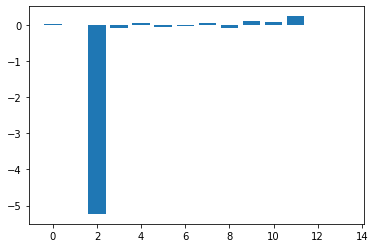

In [20]:
from matplotlib import pyplot

# get Feature improtance for logistic regression 
importance = log.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {i}, Score: {v}')
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.0
Feature: 1, Score: 0.0
Feature: 2, Score: 1.0
Feature: 3, Score: 0.0
Feature: 4, Score: 0.0
Feature: 5, Score: 0.0
Feature: 6, Score: 0.0
Feature: 7, Score: 0.0
Feature: 8, Score: 0.0
Feature: 9, Score: 0.0
Feature: 10, Score: 0.0
Feature: 11, Score: 0.0
Feature: 12, Score: 0.0
Feature: 13, Score: 0.0


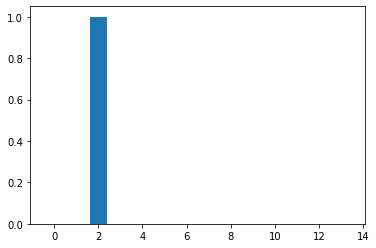

In [31]:
# get Feature improtance for Decision tree 
importance = dt.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {i}, Score: {v}')
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


Feature: 0, Score: 0.0660410365422092
Feature: 1, Score: 0.0
Feature: 2, Score: 0.7998664792069646
Feature: 3, Score: 0.005869436501217655
Feature: 4, Score: 0.0034657498379351013
Feature: 5, Score: 0.007881009884656974
Feature: 6, Score: 0.0051824836003214235
Feature: 7, Score: 0.005009106027757351
Feature: 8, Score: 0.004921191119950356
Feature: 9, Score: 0.005486966003561851
Feature: 10, Score: 0.00551204068658621
Feature: 11, Score: 0.012746296631655753
Feature: 12, Score: 0.07801820395718366
Feature: 13, Score: 0.0


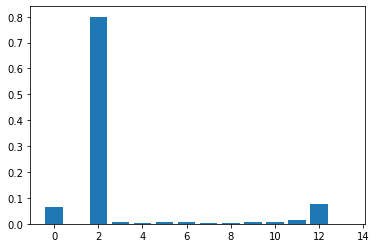

In [32]:
# get Feature improtance for Random forest  

importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {i}, Score: {v}')
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.0
Feature: 1, Score: 0.0
Feature: 2, Score: 1.0
Feature: 3, Score: 0.0
Feature: 4, Score: 0.0
Feature: 5, Score: 0.0
Feature: 6, Score: 0.0
Feature: 7, Score: 0.0
Feature: 8, Score: 0.0
Feature: 9, Score: 0.0
Feature: 10, Score: 0.0
Feature: 11, Score: 0.0
Feature: 12, Score: 0.0
Feature: 13, Score: 0.0


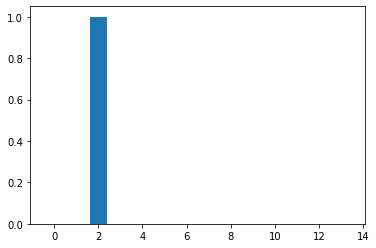

In [33]:
# get Feature improtance for Random forest  
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {i}, Score: {v}')
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()